In [1]:
import numpy as np
import pandas as pd
import os

import torch
from torch_geometric.data import Data

import sklearn
from sklearn.model_selection import StratifiedShuffleSplit

In [7]:
# Data sources.
data_root = '../data'
data_timeseries = '../data/raw_ts'
data_phenotype = '../data/phenotype.csv'
data_ct = '../data/CT.csv'
data_euler = '../data/Euler.csv'
data_computed_fcms = '../data/processed_ts'

In [4]:
def get_subject_ids(num_subjects=None, randomise=True, seed=0):
    subject_ids = np.load(os.path.join(data_root, 'subject_ids.npy'))

    if not num_subjects:
        return subject_ids

    if randomise:
        return np.random.choice(subject_ids, num_subjects, replace=False)
    else:
        return subject_ids[:num_subjects]

def get_stratified_subject_split(features, labels, test_size=0.1, random_state=0):
    train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)

    for train_validate_index, test_index in train_test_split.split(features, labels):
        features_train = features[train_validate_index]
        labels_train = labels[train_validate_index]

        train_validate_index = np.array(train_validate_index)
        test_index = np.array(test_index)

        train_validate_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=random_state)
        for train_index, validate_index in train_validate_split.split(features_train, labels_train):
            train_idx = train_validate_index[train_index]
            validate_idx = train_validate_index[validate_index]
            test_idx = test_index

            test_subject_split(train_idx, validate_idx, test_idx)
            return train_idx, validate_idx, test_idx

def extract_phenotypes(uid_list, subject_ids):
    uid_list.append('eid')
    phenotype = pd.read_csv(data_phenotype, sep=',')
    subject_ids_no_UKB = [int(i[3:]) for i in subject_ids]

    # Extract data for relevant subject IDs.
    subject_phenotype = phenotype[phenotype['eid'].isin(subject_ids_no_UKB)]

    if len(subject_phenotype) != len(subject_ids):
        print('{} entries had phenotypic data missing.'.format(len(subject_ids) - len(subject_phenotype)))

    # Extract relevant UIDs.
    subject_phenotype = subject_phenotype[uid_list]

    # Add UKB prefix back to the index.
    subject_phenotype.index = ['UKB' + str(eid) for eid in subject_phenotype['eid']]

    return subject_phenotype

In [9]:
phenotype = pd.read_csv(data_phenotype, sep=',')

/local/sdd/ks830/miniconda3/envs/brain/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (515,516,517,519) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
train_idx, _, _ = get_stratified_subject_split()

,Unnamed: 0,34-0.0,50-0.0,50-1.0,50-2.0,52-0.0,54-0.0,54-1.0,54-2.0,84-0.0,...,40006-23.0,40006-24.0,40006-25.0,40006-26.0,40006-27.0,40006-28.0,40006-29.0,40006-30.0,40006-31.0,eid
count,19891.000000,19891.000000,19869.000000,4868.000000,19439.000000,19891.000000,19891.000000,4871.0,19891.000000,1211.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.989100e+04
mean,9946.000000,1953.183249,169.548513,169.294659,169.132831,6.402896,10994.391836,11024.0,11025.306370,1685.210570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.511253e+06
std,5742.181438,7.483023,9.156549,9.110047,9.220570,3.416292,129.077233,0.0,0.720349,719.126974,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.452729e+06
min,1.000000,1936.000000,141.000000,142.000000,141.000000,1.000000,10003.000000,11024.0,11025.000000,-1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000028e+06
25%,4973.500000,1947.000000,163.000000,162.000000,162.000000,3.000000,11008.000000,11024.0,11025.000000,1989.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.247325e+06
50%,9946.000000,1953.000000,169.000000,169.000000,169.000000,6.000000,11010.000000,11024.0,11025.000000,2000.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.518224e+06
75%,14918.500000,1959.000000,176.000000,176.000000,176.000000,9.000000,11014.000000,11024.0,11025.000000,2005.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.763230e+06
max,19891.000000,1970.000000,203.000000,202.000000,203.000000,12.000000,11023.000000,11024.0,11027.000000,2010.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.025942e+06


In [14]:
phenotype.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19891 entries, 0 to 19890
Columns: 542 entries, Unnamed: 0 to eid
dtypes: float64(520), int64(10), object(12)
memory usage: 82.3+ MB


## Possibly interesting additional phenotypes for graph construction
```
54 UKB assessment centre
845 age completed full time education
10895 light smokers (pilot)
2644 light smokers
2887 number of cigarettes previously smoked daily
4548 health satisfaction
4581 financial situation satisfaction
6156 manic/hyper symptoms
20002 non-cancer illness code

20016 fluid intelligence score
20191 fluid intelligence score

20018 prospective memory result

20116 smoking status

20122 bipolar disorder status
20127 neuroticism score

87 non-cancer illness year
84 cancer year

20544 mental health problems ever diagnosed by a professional
```

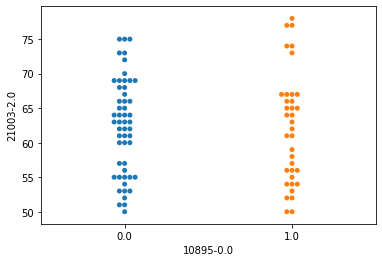

In [29]:
import seaborn as sns
# ax = sns.scatterplot(x='21003-2.0', y='20191-0.0', data=phenotype)
sns.swarmplot(x='10895-0.0', y='21003-2.0', data=phenotype)